In [168]:
import numpy as np
import math
from matplotlib import pyplot as plt
import datetime
import time as timemodule
import os
import pandas as pd
from scipy import interpolate

In [2]:
path = 'files'
filelist = os.listdir(path)
L = len(filelist)

In [3]:
filelist

['TSENSOR_6_KS.LOG',
 'tsensor_calibration.txt',
 'tsensor_calibration_time_constant_new.log',
 'TSENSOR_cleaned.LOG',
 'TSENSOR_DF.LOG',
 'TSENSOR_DKB.LOG',
 'TSENSOR_kmroz_fixed.LOG',
 'TSENSOR_LG.LOG',
 'TSENSOR_QR.LOG',
 'TSENSOR_SimonS.LOG']

# time constant

In [4]:
# load data for reference thermometer
fileREF = path + '/' + filelist[2]
tsensor_REF =pd.read_csv(fileREF, sep=',', comment='#',names=["time","temperature"])
time_REF = tsensor_REF.time.to_numpy()
temp_REF = tsensor_REF.temperature.to_numpy()

In [5]:
# claculate interpolated time series to get values in between
time_in_seconds= np.zeros(len(time_REF))
deltaT = []
for i in range(len(time_REF)):
    deltaT = datetime.datetime.strptime(time_REF[i], '%H:%M:%S') - datetime.datetime.strptime(time_REF[0], '%H:%M:%S') 
    time_in_seconds[i] = deltaT.seconds
    
new_time_vec = np.linspace(0,time_in_seconds[-1],500)
interp_temp = np.interp(new_time_vec, time_in_seconds, temp_REF)   

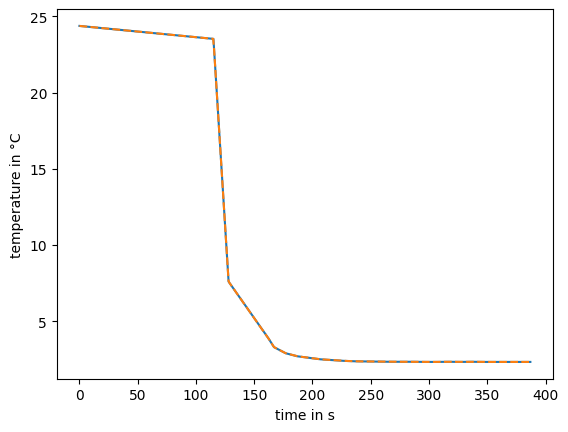

In [6]:
plt.plot(time_in_seconds, temp_REF)
plt.plot(new_time_vec, interp_temp,'--')
plt.xlabel('time in s')
plt.ylabel('temperature in °C')
plt.show()


In [7]:
# find where temperature drop declines (defined as where the temperature only changes by 0.1)
temp_diff_REF = temp_REF[:-1]-temp_REF[1:]
ind_decline = np.where(temp_diff_REF < 0.1)[0][0]

#determine temperature where 62.3% of the temperature change is reached
temp_start = temp_REF[1]
temp_end = temp_REF[ind_decline]
temp_tau = temp_end + 1/np.e *(temp_start - temp_end)

#detremine time constant tau
ind_tau = np.where(interp_temp <= temp_tau)[0][0]
time_tau = new_time_vec[ind_tau] - time_in_seconds[1]

print('time constant of reference thermometer:', round(time_tau,1),'s')

time constant of reference thermometer: 11.4 s


In [20]:
def determine_time_constant(file):

    if file == 'files/TSENSOR_DKB.LOG':
        tsensor = pd.read_csv(filename, sep=',', comment='#',names=["time","millis","ID","temperature","none"])
    else:
        tsensor = pd.read_csv(file, sep=',', comment='#',names=["time","millis","ID","temperature"])
    
    print(file)
    time = tsensor.time.to_numpy()
    millis = tsensor.millis.to_numpy()
    temp = tsensor.temperature.to_numpy()

    # find temperature drop
    I = ~np.isnan(temp)
    
    # get rid of nan
    temp = temp[I]
    time = time[I]
    millis = millis[I]

    temp_gradient = np.gradient(temp)
    ind_drop = np.argmin(temp_gradient)
    print(temp[ind_drop])
    print(temp[ind_drop-10:ind_drop+1])

    ind_correction = int(input("enter distance of index of correct start value from last value"))
    ind_start = ind_drop - ind_correction
    print('start value:',temp[ind_start])

    # find where temperature drop declines (defined as where the temperature only changes by 0.1)
    temp_diff = temp[ind_start:-1]-temp[ind_start+1:]
    ind_end = np.where(temp_diff < 0.1)[0][0] + ind_start

    #determine temperature where 62.3% of the temperature change is reached
    temp_start = temp[ind_start]
    temp_end = temp[ind_end]
    temp_tau = temp_end + 1/np.e *(temp_start - temp_end)

    #detremine time constant tau
    ind_tau = np.where(temp <= temp_tau)[0][0]
    time_tau = millis[ind_tau]

    print('time constant of thermometer:', round(time_tau,2),'ms')
    print('                             ', round(time_tau/1000,2),'s')
    #return time_tau

In [ ]:
determine_time_constant(path + '/' + filelist[5])

In [ ]:
file_KS = filename = path + '/' + filelist[0]
tsensor_KS = pd.read_csv(file_KS, sep=',', comment='#',names=["time","millis","ID","temperature"])
tsensor.plot('millis','temperature')
plt.show()

# calibration

In [22]:
fileCAL = path + '/' + filelist[1]
tsensor_CAL = pd.read_csv(fileCAL, sep=',', comment='#',names=["time","temperature"])

In [397]:
def calibration(file):
    # reference thermometer
    fileCAL = path + '/' + filelist[1]
    tsensor_CAL = pd.read_csv(fileCAL, sep=',', comment='#',names=["time","temperature"])
    time_CAL = tsensor_CAL.time.to_numpy()
    temp_CAL = tsensor_CAL.temperature.to_numpy()
    time_in_sec= np.zeros(len(time_CAL))
    deltaT = []
    for i in range(len(time_CAL)):
        deltaT = datetime.datetime.strptime(time_CAL[i], '%H:%M:%S' ) - datetime.datetime.strptime(time_CAL[0], '%H:%M:%S' )
        time_in_sec[i] = deltaT.seconds
    
    if file == 'files/TSENSOR_DKB.LOG':
        tsensor = pd.read_csv(filename, sep=',', comment='#',names=["time","millis","ID","temperature","none"])
    else:
        tsensor = pd.read_csv(file, sep=',', comment='#',names=["time","millis","ID","temperature"])

    print(file)
    time = tsensor.time.to_numpy()
    millis = tsensor.millis.to_numpy()
    temp = tsensor.temperature.to_numpy()
    # find temperature drop
    I = ~np.isnan(temp)

    # get rid of nan
    temp = temp[I]
    time = time[I]
    millis = millis[I]

    temp_gradient = np.gradient(temp)
    ind_drop = np.argmin(temp_gradient)
    print(temp[ind_drop])
    print(temp[ind_drop-10:ind_drop+1])

    ind_correction = int(input("enter distance of index of correct start value from last value"))
    ind_start = ind_drop - ind_correction
    print('start value:',temp[ind_start])

    #determine time difference to reference logger
    dT = datetime.datetime.strptime(time_REF[ind_decline], '%H:%M:%S' ) - datetime.datetime.strptime(time[ind_start], '%Y-%m-%dT%H:%M:%SZ') 
    delta_seconds = dT.seconds

    delta0 = datetime.datetime.strptime(time_CAL[0],'%H:%M:%S') - datetime.datetime.strptime(time_REF[0], '%H:%M:%S' )
    start_cal_logger = millis[ind_start]/1000 + delta0.seconds

    for i in range(len(time)):
        if start_cal_logger <= millis[i]/1000:
            ind_start_cal = i
            break

    time_in_sec_logger = millis[ind_start_cal:]/1000-millis[ind_start_cal]/1000

    # interpolate values of logger to time acis of reference thermometer
    p = np.polyfit(time_in_sec_logger, temp[ind_start_cal:],1)
    temp_interp = np.polyval(p, time_in_sec)

    P = np.polyfit(temp_interp, temp_CAL, 4)
    temp_out = np.polyval(P, temp[ind_start_cal:])
    print('linear regression values:', round(P[4],4), round(P[3],4), round(P[2],4), round(P[1],4), round(P[0],4))
    
    #calculate error for precision
    index = np.zeros(len(time_in_sec), dtype=int)
    for i in range(1,len(time_in_sec)):
        if time_in_sec[i] <= time_in_sec_logger[-1]:
            index[i] = int(np.where( time_in_sec_logger >= time_in_sec[i])[0][0])-1
        else:
            index = index[0:i]
            break
            
    err = np.zeros(len(index))
    for i in range(0,len(index)):
        err[i] = np.abs( temp_out[index[i]] - temp_CAL[i] )
    std = np.sqrt( np.sum(err**2) * 1/(len(index)) )
    error = np.sum(err)/len(index)
                   
    print('error:', round(error,5))
    print('std:', round(std,4))
    
    return time_in_sec, temp_CAL, temp, ind_start_cal, temp_interp, time_in_sec_logger, temp_out, error

In [406]:
time_in_sec, temp_CAL, temp, ind_start_cal, temp_interp, time_in_sec_logger, temp_out, error = calibration(path + '/' + filelist[0])

files/TSENSOR_6_KS.LOG
18.75
[24.31 24.31 24.31 24.38 24.31 24.38 24.31 24.38 24.31 22.13 18.75]
enter distance of index of correct start value from last value2
start value: 24.31
linear regression values: 2.3876 -0.666 0.1869 -0.0086 0.0001
error: 0.05284
std: 0.0685


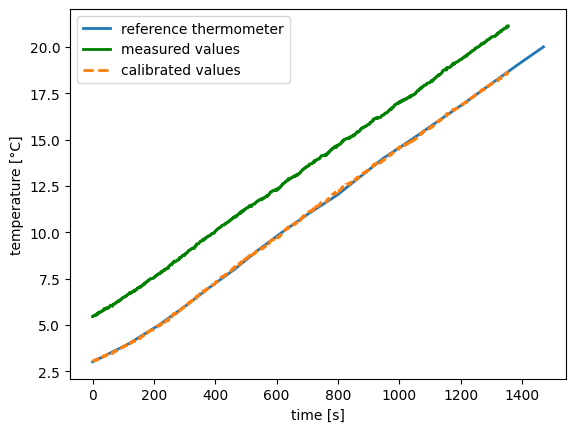

In [407]:
plt.plot(time_in_sec, temp_CAL, label='reference thermometer', linewidth=2)
plt.plot(time_in_sec_logger, temp[ind_start_cal:], 'g', label='measured values',linewidth=2)
#plt.plot(time_in_sec, temp_interp,'--', label='')
plt.plot(time_in_sec_logger, temp_out, '--', label='calibrated values',linewidth=2)
plt.legend()
plt.xlabel('time [s]')
plt.title('calibration of thermometer KS')
plt.ylabel('temperature [°C]')
plt.show()

In [351]:
error

0.14803827179309453

In [301]:
error

245.59016329617367

In [338]:
err = np.zeros(len(index))
for i in range(1,len(index)):
        err[i] = np.abs( temp_out[index[i]] - temp_CAL[i] )
error = np.sum(err)/len(index)

In [341]:
temp_out[index[0]]

18.65118847673153

In [340]:
temp_CAL[0]

3.0

In [342]:
index[0]

-1

In [274]:
i

16